# Jack's car rental problem
## Value iteration

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

In [2]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2

POISSON_UPPER_BOUND = 21

In [3]:
# all of the state-pairs possible (i, j) for "i" showing the number of cars at location1, and "j" for location2
states = [(i, j) for i in range(MAX_CARS + 1) for j in range(MAX_CARS + 1)]
# every possible actions could be done
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

In [4]:
# Calculate poisson distribution
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x * 10 + lam
    if key not in pBackup:
        pBackup[key] = np.exp(-lam) * pow(lam, x) / factorial(x)
    return pBackup[key]

In [5]:
def expected_return(state, action, state_value, constant_return=False):
    """
    args:
        state:            [# number of cars at first location, number of cars at second location]
        action:           # number of cars to move from location1 to  location2 (if negative it is vise-vera)
        state_value:      evaluated state_value function that maps each state to the expected return
        constant_return:  if True, returning car is not with respect to poission random variable
    returns:
        q(s, a) - this is same as action_value function
    """
    # cost of moving cars is applied here (See the notes at the end of the notebook, NOTE1)
    returns = -COST_OF_MOVING * np.abs(action)
    # applying the action to the state
    LOCATION1, LOCATION2 = state
    LOCATION1, LOCATION2 = min(LOCATION1 - action, MAX_CARS), min(LOCATION2 + action, MAX_CARS)

    # taking into account the enivronment dynamics
    for req_loc1 in range(LOCATION1 + 1):
        for req_loc2 in range(LOCATION2 + 1):
            # applying rent requests
            after_req_loc1, after_req_loc2 = LOCATION1 - req_loc1, LOCATION2 - req_loc2
            # calculating this particular request happening
            req_prob = poisson(req_loc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(req_loc2, EXPECTED_SECOND_LOC_REQUESTS)
            # calculating reward
            reward = RENTAL_CREDIT * (req_loc1 + req_loc2)

            # calculating for returns
            if constant_return:
                # returns are constants
                after_ret_loc1 = min(MAX_CARS, after_req_loc1 + EXPECTED_FIRST_LOC_RETURNS)
                after_ret_loc2 = min(MAX_CARS, after_req_loc2 + EXPECTED_SECOND_LOC_RETURNS)

                # Calculating return for this particular situation (See the notes at the end of the notebook, NOTE2)
                returns += req_prob * (reward + DISCOUNT_RATE * state_value[after_ret_loc1, after_ret_loc2])
            else:
                for ret_loc1 in range(POISSON_UPPER_BOUND):
                    for ret_loc2 in range(POISSON_UPPER_BOUND):
                        # applying returns
                        after_ret_loc1 = min(MAX_CARS, after_req_loc1 + ret_loc1)
                        after_ret_loc2 = min(MAX_CARS, after_req_loc2 + ret_loc2)
                        # calculating this particular return happening
                        ret_prob = poisson(ret_loc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(ret_loc2, EXPECTED_SECOND_LOC_RETURNS)

                        # Calculating return for this particular situation (See the notes at the end of the notebook, NOTE2)
                        returns += ret_prob * req_prob * (reward + DISCOUNT_RATE * state_value[after_ret_loc1, after_ret_loc2])

    return returns

In [6]:
def value_iteration(constant_return = False, theta=1e-8, verbose=True):
    """
        constant_return:  if True, returning car is not with respect to poission random variable
        theta:            evaluation accuracy, default value if 1e-8
        verbose:          prints out progress
    returns:
        state_value:      evaluated state_value function that maps each state to the expected return
    """
    state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=np.float64)
    sweep = 0
    while True:
        old_state_value = state_value.copy()
        for state in states:
            state_value[state] = np.max([expected_return(state, action, state_value, constant_return) for action in actions])
        delta = np.abs(state_value - old_state_value).max()
        sweep += 1
        if verbose:
            print(f'\rSweep {sweep:>3} delta is {delta:0.3e}', end='')
        if delta < theta:
            policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=np.int32)
            for state in states:
                max_expected_return = None
                best_action = 0
                for action in actions:
                    q = expected_return(state, action, state_value, constant_return)
                    if max_expected_return is None or max_expected_return < q:
                        best_action = action
                        max_expected_return = q
                policy[state] = best_action
            return state_value, policy


In [7]:
state_value, policy = value_iteration(constant_return=True)

Sweep  37 delta is 8.941e-09

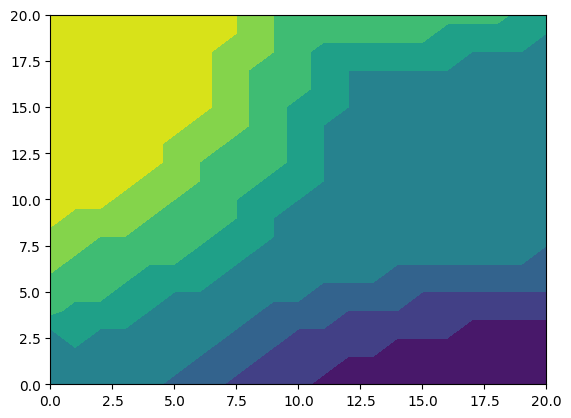

In [8]:
plt.contourf(policy)

In [9]:
print(policy)

[[ 0  0  0  0 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [ 0  0  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [ 0  0  0  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -4 -5 -5 -5 -5 -5 -5 -5]
 [ 0  1  0  0  0  0 -1 -1 -2 -2 -3 -3 -3 -4 -4 -4 -4 -5 -5 -5 -5]
 [ 2  1  1  1  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -4 -4 -4 -4 -4]
 [ 2  2  2  1  1  0  0  0 -1 -1 -1 -2 -2 -2 -2 -3 -3 -3 -3 -3 -3]
 [ 3  3  2  2  1  1  1  0  0  0 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2 -2]
 [ 4  3  3  2  2  2  1  1  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -2]
 [ 4  4  3  3  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [ 5  4  4  4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  4  4  3  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  4  4  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  4  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  5  4  4  3  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5

- NOTE1: Mainly we write $q_\pi(s, a) = \sum_{s^\prime, r}p(s^\prime, r | s, a)\big[r + \gamma v_\pi(s^\prime)\big]$ as the expected return formula. However we are adding a part of the reward at the very first, since it is constant reward for doing some action and even if we put it together with ```reward``` calculated with the code (action_reward + reward) it would have been the same.
- NOTE2: Expected return is actually $q_\pi(s, a)$ given that we are in state $s$ and we are doing action $a$; we want to know what the return will be.<br>
If we do some action then environment might act stochastically, in this case, renting and returning is what environment is supposed to do. So we average over the return of each future state.